In [130]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams["figure.figsize"] = (12,8)

# Answer A)

range of pixel values for apple images 0 , 255
range of pixel values for mask 0.0 , 1.0


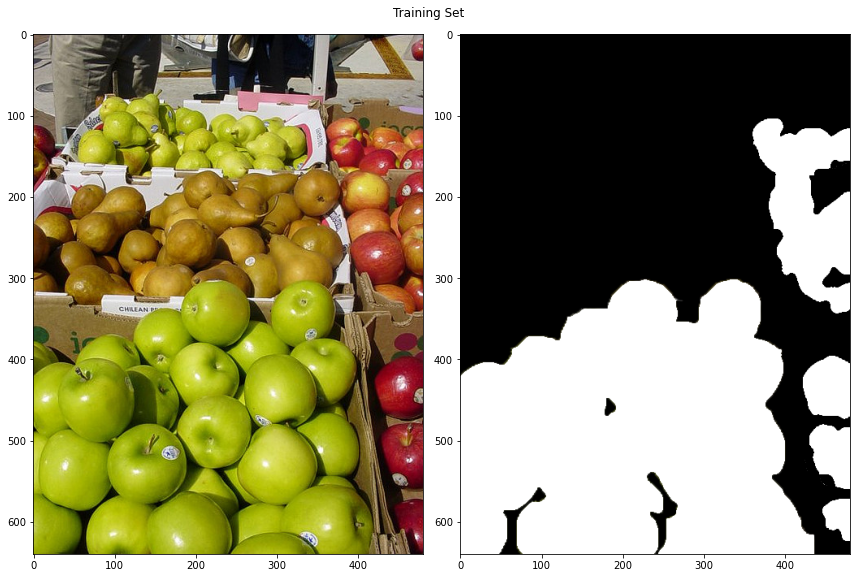

In [131]:
files_jpg = glob.glob("apples/*.jpg")
files_png = glob.glob("apples/*.png")
apple = plt.imread(files_jpg[0])
mask = plt.imread(files_png[0])

print("range of pixel values for apple images",apple.min(),",",apple.max())
print("range of pixel values for mask",mask.min(),",",mask.max())
fig,ax = plt.subplots(1,2)
ax[0].imshow(apple);
ax[1].imshow(mask);
fig.suptitle("Training Set")
fig.tight_layout()

In [3]:
# format the input files for training and testing

def fetch_files(files_img,files_mask):

    ColorImgs = []
    MaskImgs = []
    for i in range(len(files_img)):
        im_apple = plt.imread(files_img[i])/255 # normalizing the data 
        ColorImgs.append(im_apple)
        
        # masks
    for i in range(len(files_mask)):
        im_mask = plt.imread(files_mask[i])
        im_mask = im_mask[:,:,2] > 0.5 # randomly selecting the green channel 
                                       # mask value greater than 0.5 will be considered 'apple' pixel and lesser 'non apple'
        MaskImgs.append(im_mask)
    return ColorImgs,MaskImgs

files_jpg = glob.glob("apples/*.jpg")
files_png = glob.glob("apples/*.png")

ColorImgs,MaskImgs = fetch_files(files_jpg,files_png)

In [4]:
# extract apple and non apple pixel
def extract_pixels_from_mask(list_img,list_mask):
    apple_px = []
    non_apple_px = []

    for i in range(len(list_img)):
        
        apple_px_i = list_img[i][list_mask[i]]
        apple_px.append(apple_px_i.reshape(-1,3))
        
        non_apple_px_i = list_img[i][~list_mask[i]]
        non_apple_px.append(non_apple_px_i.reshape(-1,3) )
    
    apple_px = np.vstack(apple_px)
    non_apple_px = np.vstack(non_apple_px)
    return apple_px,non_apple_px
 
apple_px,non_apple_px = extract_pixels_from_mask(ColorImgs,MaskImgs)

apple_px.shape, non_apple_px.shape

((425686, 3), (374614, 3))

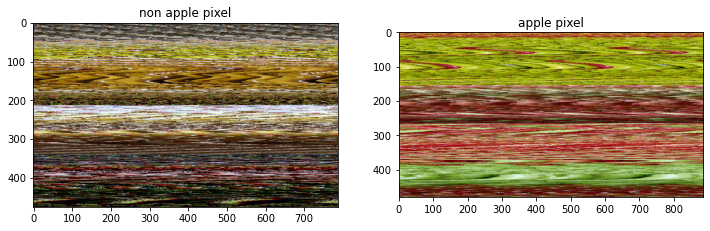

In [70]:
fig,ax = plt.subplots(1,2)
# roughly display the apple pixels
ax[0].imshow(non_apple_px[:-2,:].reshape(476 ,787 ,3))
ax[0].title.set_text('non apple pixel')
ax[1].imshow(apple_px[:-1,:].reshape(481,885,3))
ax[1].title.set_text('apple pixel')

# Answer B)

In [6]:
def getGaussProbD(x,mean,cov):       
    dim = x.shape[0]     
    mean = mean.reshape(-1,1)   
    
    A =  (x - mean)
    # adding a small error to the cov to avoid singular matrix error
    error = np.eye(dim)* 1e-4
    
    B = A.T @ np.linalg.inv(cov+error)
    C = np.einsum('ij,ji->i',B,A)

    prob = np.exp(-0.5* C)
    prob = prob/ np.sqrt( 2*np.pi* np.linalg.det(cov+error))
    return prob 

In [7]:
def getMixGaussLogLike(data, mixGaussEst): 
                                                                             
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;   
    weight = mixGaussEst['weight']  
    mean =   mixGaussEst['mean']  
    cov =   mixGaussEst['cov'] 

    # vectorised form
    like=np.zeros((mixGaussEst['k'],data.shape[1]))
    for k in range(mixGaussEst['k']):
        like[k,:] = weight[k]*getGaussProbD(data,mean[:,k],cov[:,:,k])

    logLike = np.log(np.sum(like,axis=0))                                                              
                                                                                                       
    return  np.asscalar(np.sum(logLike))                                                                       
                      

In [57]:
# Calculate the MoG estimates
# K = 3 and nIter = 100 were chosen by trial and error
# further scope of tuning the hyper parameters with grid search etc. using validation set

def fitMixGauss(data, k=3,nIter=100 ):

    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
 
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    

    #nIter = 50;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

   

    mean = mixGaussEst['mean']
    cov = mixGaussEst['cov']
    weight = mixGaussEst['weight']
   
    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for ki in range(k):

            postHidden[ki,:] = weight[ki] * getGaussProbD(data,mean[:,ki],cov[:,:,ki])

        postHidden /= postHidden.sum(axis = 0) 



        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            
            mixGaussEst['weight'][cGauss] = postHidden[cGauss].sum()/postHidden.sum()

            mixGaussEst['mean'][:,cGauss] = data @ postHidden[cGauss] / postHidden[cGauss].sum()
       
            cov_k = postHidden[cGauss,:] * (data - mixGaussEst['mean'][:,cGauss].reshape(-1,1)) \
                    @ (data - mixGaussEst['mean'][:,cGauss].reshape(-1,1)).T

            mixGaussEst['cov'][:,:,cGauss] = cov_k / postHidden[cGauss].sum()
         
        log_like_list = []
        logLike = getMixGaussLogLike(data, mixGaussEst)
        log_like_list.append(logLike)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        
        


    return mixGaussEst, logLike

In [58]:
k=3
mixGaussEst_apple , _ = fitMixGauss(apple_px.T)
mixGaussEst_non_apple , _= fitMixGauss(non_apple_px.T)

C:\Users\SULAKS~1\AppData\Local\Temp/ipykernel_21556/109793051.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return  np.asscalar(np.sum(logLike))


Log Likelihood Iter 0 : -1689075.003

Log Likelihood After Iter 0 : 1065805.512

Log Likelihood After Iter 1 : 1066954.479

Log Likelihood After Iter 2 : 1097647.603

Log Likelihood After Iter 3 : 1256712.459

Log Likelihood After Iter 4 : 1347455.133

Log Likelihood After Iter 5 : 1396238.260

Log Likelihood After Iter 6 : 1430446.426

Log Likelihood After Iter 7 : 1454398.280

Log Likelihood After Iter 8 : 1469097.446

Log Likelihood After Iter 9 : 1476617.945

Log Likelihood After Iter 10 : 1480288.282

Log Likelihood After Iter 11 : 1482299.723

Log Likelihood After Iter 12 : 1483667.329

Log Likelihood After Iter 13 : 1484771.099

Log Likelihood After Iter 14 : 1485764.229

Log Likelihood After Iter 15 : 1486709.294

Log Likelihood After Iter 16 : 1487627.743

Log Likelihood After Iter 17 : 1488522.994

Log Likelihood After Iter 18 : 1489392.009

Log Likelihood After Iter 19 : 1490231.167

Log Likelihood After Iter 20 : 1491038.567

Log Likelihood After Iter 21 : 1491816.216

Log 

In [59]:
# test time

# setting prior as portion of pixel vs non pixel 
# data seen during training time

n_apple_px = apple_px.shape[0]
n_non_apple_px = non_apple_px.shape[0]


prior_apple = n_apple_px/(n_apple_px+n_non_apple_px)
prior_non_apple = 1-prior_apple

print(prior_non_apple,prior_apple)

0.46809196551293264 0.5319080344870674


In [73]:
# fetch test data set

testFiles_jpg = glob.glob("testApples/*.jpg")
testFiles_png = glob.glob("testApples/*.png")

test_imgs, test_masks = fetch_files(testFiles_jpg,testFiles_png)

In [127]:
# calculate posterier probability of each pixel

test_img = test_imgs[3].reshape(-1,3) 
#test_img = test_imgs[0]
def get_post_prob(data):
    nData,nDim = data.shape

    post_prob_apple = np.zeros(nData)

    mean_apple = mixGaussEst_apple['mean']
    cov_apple = mixGaussEst_apple['cov']
    weight_apples = mixGaussEst_apple['weight']

    mean_non_apple = mixGaussEst_non_apple['mean']
    cov_non_apple = mixGaussEst_non_apple['cov']
    weight_non_apples = mixGaussEst_non_apple['weight']

    like_apple_px = np.zeros((k,nData))
    like_non_apple_px = np.zeros((k,nData))

    for i in range(k):
        like_apple_px[i,:] = weight_apples[i] * getGaussProbD(data.T,mean_apple[:,i],cov_apple[:,:,i])
        like_non_apple_px[i,:] = weight_non_apples[i] * getGaussProbD(data.T,mean_non_apple[:,i],cov_non_apple[:,:,i])

    prob_px = like_apple_px.sum(axis = 0) * prior_apple + like_non_apple_px.sum(axis = 0) * prior_non_apple
    post_prob_apple[:] = (like_apple_px.sum(axis = 0) * prior_apple) / prob_px

    return post_prob_apple


post_prob_apple = get_post_prob(test_img)

# Answer D)

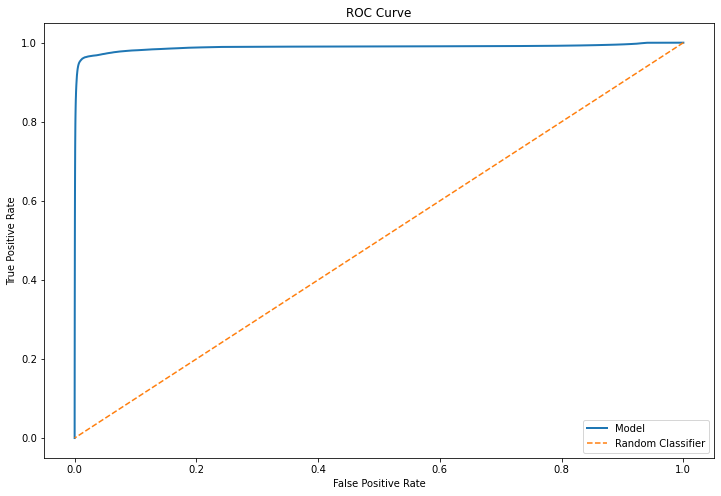

In [125]:
# computr ROC

def calculateROC(post_prob_apple,mask):
    thresh = np.linspace(0,1,100)
    tpr = []
    fpr = []
    for t in thresh:
        m = post_prob_apple > t
        mask_test = mask.reshape(-1,1).squeeze()
        total_positives = np.sum(mask_test)

        true_postives = np.sum(m * mask_test) 
        False_negative = np.sum(~m * mask_test )
        #p = False_negative + true_postives
        tpr.append( true_postives / total_positives)
        total_negatives = np.sum(~mask_test)
        #true_negative = np.sum
        fasle_positives =  np.sum(m * ~mask_test)
        fpr.append(fasle_positives / total_negatives)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
  
    
    plt.plot(fpr,tpr,label = 'Model',linewidth = 2) 
    plt.plot(tpr,tpr,'--',label = 'Random Classifier')
    plt.legend()

calculateROC(post_prob_apple,test_masks[0])

### Observing the ROC curve, we can see that the curve is very close to the upper left corner. Eyeballing the area under the curve (AUC) we can infere that it is close to 1. The model has displayed high sensitity and high specificity, hence on this data set performance of the model is very good.

# Answer C)

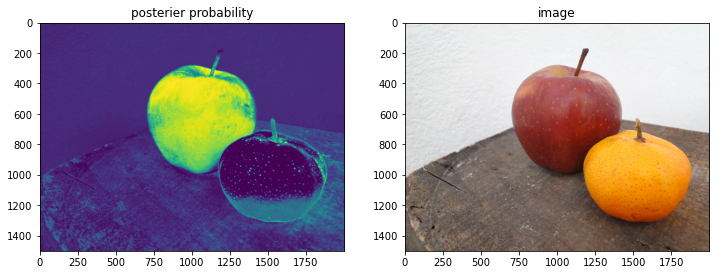

In [124]:
# Visualize the posterier probability of the test set with the given ground truth mask

post = post_prob_apple.reshape(1500,2000)
fig,ax = plt.subplots(1,2)
ax[0].imshow(post)
ax[0].title.set_text('posterier probability')
img = test_imgs[3]
ax[1].imshow(img)
ax[1].title.set_text('image')

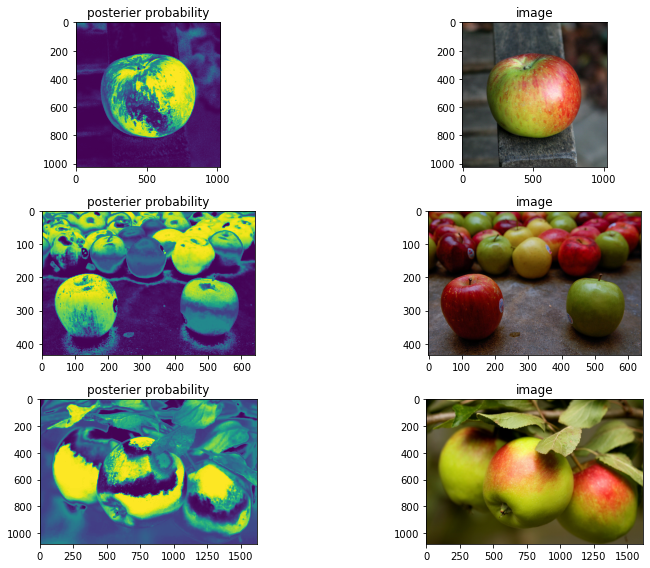

In [65]:
# Visualize the posterier probability of the test set

post_probs = []
fig,ax = plt.subplots(3,2)

for i in range(len(test_imgs)-1):
    data = test_imgs[i].reshape(-1,3)
    mask_shape = test_imgs[i].shape[:2]
    post_probs = get_post_prob(data)
    ax[i,0].imshow(post_probs.reshape(mask_shape))
    ax[i,0].title.set_text('posterier probability')
    img = test_imgs[3]
    ax[i,1].imshow(test_imgs[i])
    ax[i,1].title.set_text('image')

plt.tight_layout()

### We can see that the posterir probability is the most confident when the pixels are red, followed by green pixels. The model doesn't perform well around the pixels where there is a gradient from green to red. 

### Due to random initialization of the parameters, the model sometimes converges to a local maxima which does a good job at describing the data. Hence with repeated fitting, we can find a good fit of the model.

# Answer E)

(1024, 1024, 3) (1024, 1024, 3)


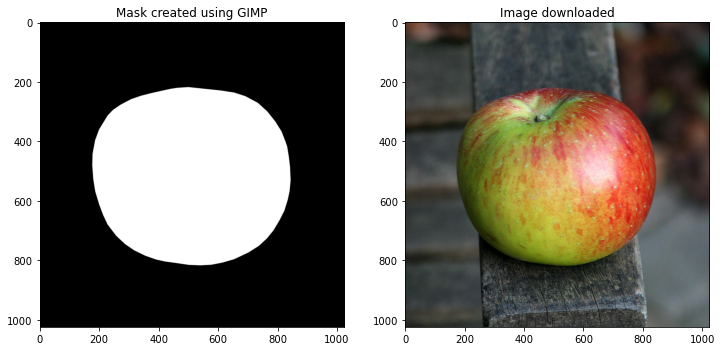

In [94]:
# View the non-copyrighted image downloaded from the net along with the ground truth mask created from Gimp

mask_gimp_png = glob.glob("testApples/c_282363160_79c42b730a_b_mask.png")
mask_gimp = plt.imread(files_png[0])

files_test_img_jpg= glob.glob("testApples/282363160_79c42b730a_b.jpg")
test_img = plt.imread(files_jpg[0])

fig,ax = plt.subplots(1,2)

ax[0].imshow(mask_gimp);
ax[0].title.set_text('Mask created using GIMP')
ax[1].imshow(test_img)
ax[1].title.set_text('Image downloaded')

print(mask_gimp.shape,test_img.shape)

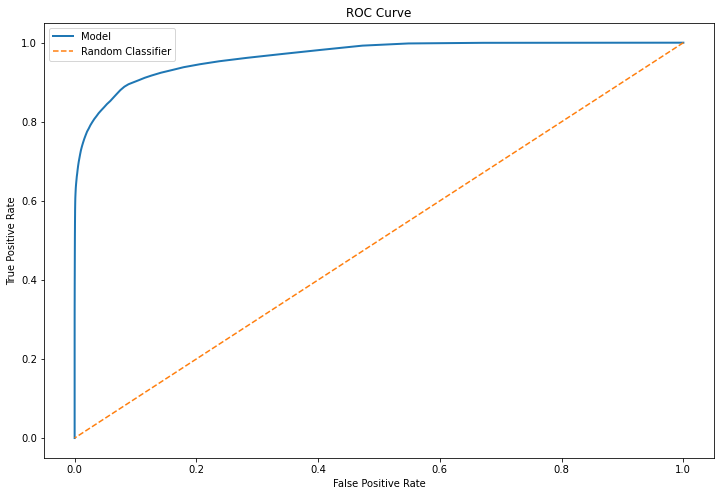

In [126]:
# plot ROC 
# fetch data in required format

test_gimp_imgs, test_gimp_masks = fetch_files(files_test_img_jpg,mask_gimp_png)
test_gimp_img = test_gimp_imgs[0].reshape(-1,3)

post_test_gimp = get_post_prob(test_gimp_img)

mask_gimp = test_gimp_masks[0].reshape(-1,1)
calculateROC(post_test_gimp,mask_gimp)



### Observing the ROC curve for the ground truth mask and the image, we see that the curve is close to the top left corner and hence the test performance is good. Making the mask more preciese might result in a better ROC curve.

# Answer F)

###  We should ideally be using 3 seperate sets of files: a training set, a validation set, and a test set. This is because we also have hyper paramerets 'k' ( number of hidden varibales in MoG) and 'n' ( number of iterations for model training). If we tune the parametrs using the training set then we end up over fitting the model on training data. Hence we need another set of files such as a validation set on which we can tune the parameters and evaluate the trained model. Once tuning and training is completed, to mearuse the performance of the model we use the test set.